# Autoregressive Models

# Goal of the Autoregressive Model

Given a scalar time series \( x_t \), train a small neural network to predict the next value using the previous `embedding` values.

In other words, learn a function \( f \) such that:

\[
\hat{x}_t = f(x_{t-\text{embedding}}, \dots, x_{t-1})
\]

Where:
- \( \hat{x}_t \) is the predicted value at time \( t \)
- The inputs are the previous `embedding` values
- The output is a single scalar prediction

---

# Approach

## 1. Generate or Load a 1D Time Series

Create a synthetic time series (commonly a sine wave with added noise), or load a real-world dataset.

Example idea:
- Sine wave
- Add Gaussian noise
- Length \( T \)

---

## 2. Build the Supervised Dataset (Sliding Window)

Convert the time series into input-output pairs using a sliding window of size `embedding`.

For each time step:

- **Input (feature vector):**
\[
[x_{t-\text{embedding}}, \dots, x_{t-1}]
\]

- **Target:**
\[
x_t
\]

This transforms the time series into a standard regression dataset.

---

## 3. Split Into Train and Test Sets

Divide the dataset into:
- Training set (e.g., first 80%)
- Test set (remaining 20%)

This allows evaluation of generalization performance.

---

## 4. Build a Small Feedforward Neural Network

Typical architecture:
Linear(embedding → hidden_units)
ReLU
Linear(hidden_units → 1)


The network:
- Takes `embedding` inputs
- Outputs a single scalar prediction

---

## 5. Train the Model

Use:

- **Loss function:** Mean Squared Error (MSE)
\[
\text{MSE} = \frac{1}{N} \sum (x_t - \hat{x}_t)^2
\]

- **Optimizer:** Adam

Train for multiple epochs using minibatches.

---

## 6. Evaluate and Visualize

### One-Step Prediction

Use true previous values as inputs and predict the next value.

This shows how well the model performs when given correct history.

---

### Multi-Step Prediction (Free-Running)

Instead of feeding true past values:

- Feed the model’s own predictions back as inputs
- Generate predictions recursively

This demonstrates:
- Long-term behavior
- Stability of the learned dynamics
- Error accumulation effects

---

# Summary

This process turns time-series prediction into a supervised learning problem by:

1. Using sliding windows
2. Learning a nonlinear regression function
3. Evaluating both short-term and long-term predictive behavior

It highlights the difference between:
- Accurate local predictions
- Stable long-term dynamical modeling

# Network Architecture in Mathematical Form

Let the input vector at time \( t \) be

$$
\mathbf{x}_t =
\begin{bmatrix}
x_{t-\text{embedding}} \\
x_{t-\text{embedding}+1} \\
\vdots \\
x_{t-1}
\end{bmatrix}
\in \mathbb{R}^{\text{embedding}}
$$

---

## First Linear Layer

The first linear transformation is:

$$
\mathbf{h}_t = W_1 \mathbf{x}_t + \mathbf{b}_1
$$

where

$$
W_1 \in \mathbb{R}^{\text{hidden\_units} \times \text{embedding}}
$$

$$
\mathbf{b}_1 \in \mathbb{R}^{\text{hidden\_units}}
$$

$$
\mathbf{h}_t \in \mathbb{R}^{\text{hidden\_units}}
$$

---

## ReLU Activation

Apply the nonlinearity elementwise:

$$
\mathbf{z}_t = \mathrm{ReLU}(\mathbf{h}_t)
$$

where

$$
\mathrm{ReLU}(u) = \max(0, u)
$$

Component-wise:

$$
z_{t,i} = \max(0, h_{t,i})
$$

---

## Final Linear Layer

The final prediction is:

$$
\hat{x}_t = W_2 \mathbf{z}_t + b_2
$$

where

$$
W_2 \in \mathbb{R}^{1 \times \text{hidden\_units}}
$$

$$
b_2 \in \mathbb{R}
$$

$$
\hat{x}_t \in \mathbb{R}
$$

---

# Complete Model Equation

Putting everything together:

$$
\hat{x}_t
=
W_2 \, \mathrm{ReLU}\!\left( W_1 \mathbf{x}_t + \mathbf{b}_1 \right)
+ b_2
$$

This defines the learned function

$$
\hat{x}_t = f(\mathbf{x}_t)
$$

where

$$
\mathbf{x}_t =
(x_{t-\text{embedding}}, \dots, x_{t-1})
$$

---

# Important Note

If we removed the ReLU activation, the model would reduce to a purely linear autoregressive model:

$$
\hat{x}_t = W \mathbf{x}_t + b
$$

The ReLU introduces nonlinearity, allowing the network to model nonlinear time dynamics.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# ---------- Hyperparameters ----------
embedding = 4    # how many past points we use to predict the next
T = 1000         # total length of time series
torch.manual_seed(0)
np.random.seed(0)

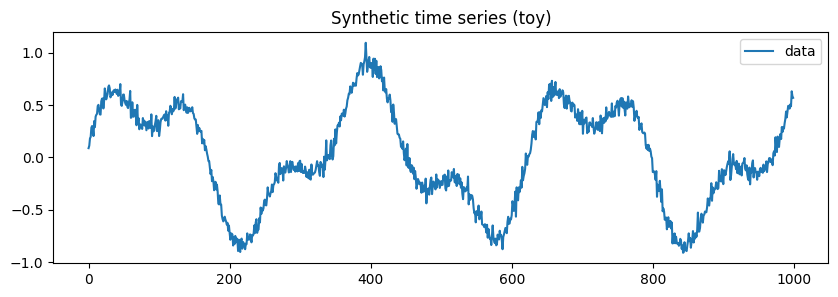

In [8]:
# ---------- Generate synthetic time series ----------
time = torch.arange(0.0, T)
# a mixture of sines + small noise (typical toy dataset)
x = 0.6 * torch.sin(0.02 * time) + 0.3 * torch.sin(0.05 * time + 0.5) + 0.05 * torch.randn(T)

plt.figure(figsize=(10,3))
plt.plot(time.numpy(), x.numpy(), label='data')
plt.title("Synthetic time series (toy)")
plt.legend()
plt.show()

In [9]:

# ---------- Build sliding-window features / targets ----------
N = T - embedding               # number of supervised samples
features = torch.zeros((N, embedding))
targets = torch.zeros((N, 1))

for i in range(N):
    features[i] = x[i:i+embedding]      # input: window of length `embedding`
    targets[i] = x[i + embedding]       # target: next value


print("features shape:", features.shape, "targets shape:", targets.shape)

features shape: torch.Size([996, 4]) targets shape: torch.Size([996, 1])


In [10]:
# ---------- Train/test split ----------
ntrain = int(0.8 * N)
train_X = features[:ntrain]
train_y = targets[:ntrain]
test_X = features[ntrain:]
test_y = targets[ntrain:]


In [11]:
# ---------- Define a small feedforward network ----------
def get_net(hidden_units=50):
    return nn.Sequential(
        nn.Linear(embedding, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, 1)
    )

net = get_net()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# ---------- Training loop ----------
def train_net(net, train_X, train_y, epochs=200, batch_size=32):
    net.train()
    n = train_X.shape[0]
    for epoch in range(epochs):
        perm = torch.randperm(n)
        epoch_loss = 0.0
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            xb = train_X[idx]
            yb = train_y[idx]
            optimizer.zero_grad()
            preds = net(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.shape[0]
        epoch_loss /= n
        if (epoch+1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}  loss={epoch_loss:.6f}")
    return net

net = train_net(net, train_X, train_y, epochs=500, batch_size=32)

Epoch 1/500  loss=0.184977
Epoch 50/500  loss=0.004259
Epoch 100/500  loss=0.004209
Epoch 150/500  loss=0.004122
Epoch 200/500  loss=0.004138
Epoch 250/500  loss=0.004150
Epoch 300/500  loss=0.004173
Epoch 350/500  loss=0.004111
Epoch 400/500  loss=0.004094
Epoch 450/500  loss=0.004038
Epoch 500/500  loss=0.004150


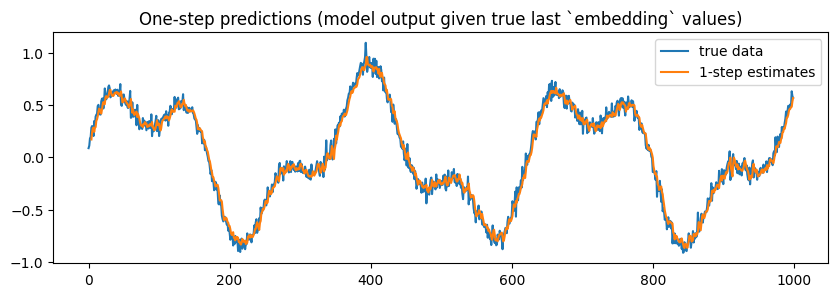

In [12]:
# ---------- Compute estimates on full features ----------
net.eval()
with torch.no_grad():
    estimates = net(features).squeeze()     # shape (N,)

# We need to align plotting indices: estimates correspond to time indices embedding..T-1
plt.figure(figsize=(10,3))
plt.plot(time.numpy(), x.numpy(), label='true data')
plt.plot(time[embedding:].numpy(), estimates.numpy(), label='1-step estimates')
plt.legend()
plt.title("One-step predictions (model output given true last `embedding` values)")
plt.show()


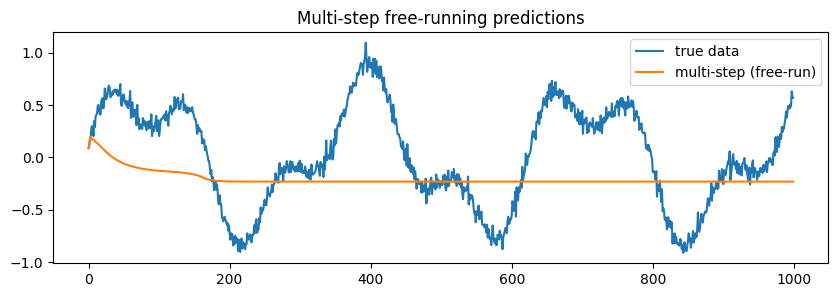

In [13]:
# ---------- Multi-step (free-running) prediction ----------
# We'll predict from scratch: start with the first `embedding` true values,
# then iteratively use predictions as inputs to produce the next value.
multi = torch.zeros(T)
multi[:embedding] = x[:embedding]   # initialize with true first `embedding` values

net.eval()
with torch.no_grad():
    for t in range(embedding, T):
        window = multi[t-embedding:t].reshape(1, -1)   # shape (1, embedding)
        pred = net(window).item()
        multi[t] = pred

plt.figure(figsize=(10,3))
plt.plot(time.numpy(), x.numpy(), label='true data')
plt.plot(time.numpy(), multi.numpy(), label='multi-step (free-run)')
plt.legend()
plt.title("Multi-step free-running predictions")
plt.show()

In [ ]:
# Understanding the Two Plots in the Autoregressive Model

These two plots demonstrate a very important concept in autoregressive time-series modeling.

---

#  Multi-step Free-Running Predictions

**Title:** Multi-step free-running predictions  

### What is shown:

- **Blue line** → True time series (real data)
- **Orange line** → Model predictions when it feeds on its own outputs

### What happens?

At the beginning:
- The model starts with real values.
- Predictions look reasonable.

But very quickly:
- The orange line collapses to a nearly constant value (around -0.25).
- It stops following the oscillating sine-wave pattern.
- It becomes almost flat.

---

## Why does this happen?

This is called **free-running prediction**.

What that means:

1. At time `t`, the model predicts `x̂_t`
2. That predicted value is fed back as input for the next prediction
3. Small errors accumulate
4. The model drifts away from the true signal

This phenomenon is known as:

> **Error accumulation in autoregressive rollout**

The model was trained to predict the next value given correct past values.  
It was NOT trained to recover from its own mistakes.

So once predictions start being slightly wrong, the errors compound over time.

---

## Why does it collapse to a constant?

Neural networks often learn something like:

\[
x_{t+1} ≈ f(x_t, x_{t-1}, ...)
\]

If the internal dynamics settle into a stable fixed point:

\[
x = f(x)
\]

The system converges to a constant value.

This is very common in:
- Small embedding sizes
- Simple MLP autoregressive models
- Models trained only on one-step prediction

---

#  One-Step Predictions

**Title:** One-step predictions (model output given true last `embedding` values)

### What is shown:

- **Blue line** → True signal
- **Orange line** → Model predictions using true previous values

Here the model performs very well:
- It tracks the sine pattern
- It follows oscillations
- It captures small noise patterns

---

## Why does this work well?

This is called **teacher forcing**.

Each prediction uses:
- The true previous values
- Not the model’s own outputs

So errors do NOT accumulate.

Mathematically:

\[
\hat{x}_t = f(x_{t-embedding}, ..., x_{t-1})
\]

Since the inputs are correct, predictions stay accurate.

---

#  Key Lesson

| Mode | Input Used | Stability |
|------|------------|-----------|
| One-step | True previous values | Stable |
| Multi-step | Model’s own predictions | Often unstable |

Your model is good at:
- Local regression (short-term prediction)

Your model struggles with:
- Long-term dynamic simulation

---

# Why the Model Fails in Free-Run

Possible reasons:

1. `embedding = 4` is too small
2. Using a simple MLP (no memory mechanism)
3. Trained only on one-step loss
4. No robustness training to noisy inputs

The model never learned long-term dynamics.

---

# Why This Matters

This is exactly why more advanced models were developed:

- RNNs
- LSTMs
- GRUs
- Transformers
- Scheduled sampling methods

Naive autoregressive MLPs typically do not handle long rollouts well.

---

# How to Improve Multi-Step Stability

### 1. Increase embedding size
Use a larger context window.

### 2. Use an LSTM instead of MLP
Recurrent networks handle temporal dependencies better.

### 3. Train with multi-step loss
Unroll predictions during training and compute loss over multiple steps.

### 4. Add noise during training
Teach the model to recover from imperfect inputs.

---

# Simple Intuition

One-step prediction:
> "If I always tell the model the correct history, it predicts well."

Multi-step prediction:
> "If I let the model rely on itself, small mistakes grow and it collapses."

---

This behavior is normal in simple autoregressive neural networks and highlights the difference between short-term prediction accuracy and long-term dynamical stability.